In [8]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
print(torch.cuda.is_available())

False


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=1000, colored_noise=False, sigma=0.01, train_percentage=80)


# Choosing the NARX parameters, loss function and optimizer
One can create a NARXNN object and choose the maximum lag of both input and output for building the regressor matrix to serve as input of the network.

In addition, you can choose the loss function, the optimizer, the optional parameters of the optimizer, the number of epochs.

Because we built this feature on top of Pytorch, you can choose any of the loss function of the torch.nn.functional. Click here for a list of the loss functions you can use. You just need to pass the name of the loss function you want.

Similarly, you can choose any of the optimizers of the torch.optim. Click here for a list of optimizers available.

In [10]:
basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    epochs=2000,
    verbose=False,
    device="cuda",
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    },  # optional parameters of the optimizer
)

In [11]:
basis_function = Polynomial(degree=1)

regressors = regressor_code(
    X=x_train,
    xlag=2,
    ylag=2,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function,
)

n_features = regressors.shape[0]  # the number of features of the NARX net
n_features

4

In [13]:
print(regressors)

[[1001]
 [1002]
 [2001]
 [2002]]


#### NARX Nöral ağımızı build edelim

In [14]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(n_features, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

narx_net.net = NARX()
if device == "cuda":
    narx_net.net.to(torch.device("cuda"))

#### Fit ve predict kısmı

In [15]:
narx_net.fit(X=x_train, y=y_train, X_test=x_valid, y_test=y_valid)

yhat = narx_net.predict(X=x_valid, y=y_valid)

In [18]:
x_train

array([[ 1.03371762e-01],
       [ 1.44673666e-01],
       [-7.69757723e-01],
       [-3.30716536e-01],
       [-2.76575770e-01],
       [ 4.36694008e-01],
       [-4.06621394e-01],
       [-2.71253855e-01],
       [-5.25088681e-01],
       [-1.50260799e-01],
       [-6.43607566e-01],
       [-4.09553905e-01],
       [ 9.68341853e-01],
       [-3.06924244e-01],
       [ 6.35866281e-01],
       [ 1.27886289e-01],
       [-3.69171715e-01],
       [-5.95588440e-01],
       [ 8.12051395e-03],
       [-8.98568061e-01],
       [ 4.25611128e-01],
       [-2.37109845e-02],
       [-7.02043868e-01],
       [ 4.74020704e-01],
       [-2.78076082e-01],
       [-6.95458115e-01],
       [ 1.59847032e-01],
       [-8.47576877e-01],
       [ 3.83271340e-01],
       [-6.22694146e-01],
       [-2.47569453e-01],
       [-5.23299949e-01],
       [-9.92980512e-01],
       [-4.77578548e-01],
       [ 4.27671157e-02],
       [ 5.95063940e-01],
       [ 2.57459406e-01],
       [ 2.41720867e-01],
       [ 3.9

In [16]:
yhat

array([[-0.06647567],
       [-0.33970836],
       [ 0.15640987],
       [ 0.07445066],
       [ 0.8838512 ],
       [ 0.30071938],
       [ 0.9908681 ],
       [ 0.90343994],
       [-0.15663318],
       [-0.38068247],
       [ 0.6543856 ],
       [ 0.9827037 ],
       [ 0.79844075],
       [ 0.55997336],
       [-0.04924129],
       [ 0.31739238],
       [ 0.464128  ],
       [ 0.07016356],
       [-0.14939685],
       [ 0.73612154],
       [ 0.36377367],
       [ 0.09680244],
       [-0.00609955],
       [-0.06858324],
       [ 0.6564989 ],
       [ 0.62828195],
       [-0.65576005],
       [-0.28510737],
       [-0.18935545],
       [-0.77757376],
       [-0.36536786],
       [ 0.46001077],
       [ 0.41785175],
       [-0.20252399],
       [-0.69982207],
       [-0.54232687],
       [-0.4236122 ],
       [-0.22758506],
       [ 0.1651446 ],
       [ 0.7379904 ],
       [-0.47173643],
       [ 0.07160841],
       [-0.2834907 ],
       [ 0.2559432 ],
       [ 0.30351663],
       [ 0

MSE:  0.00012127673813374279


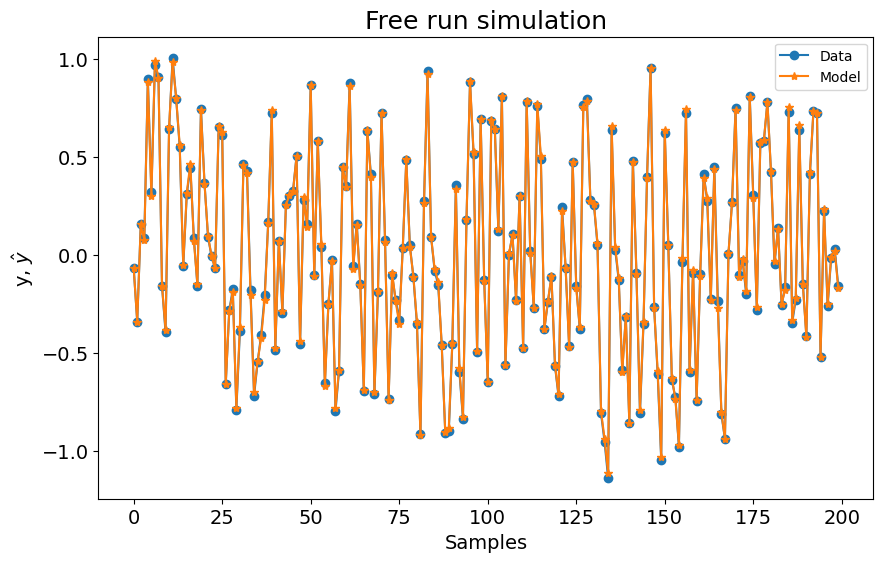

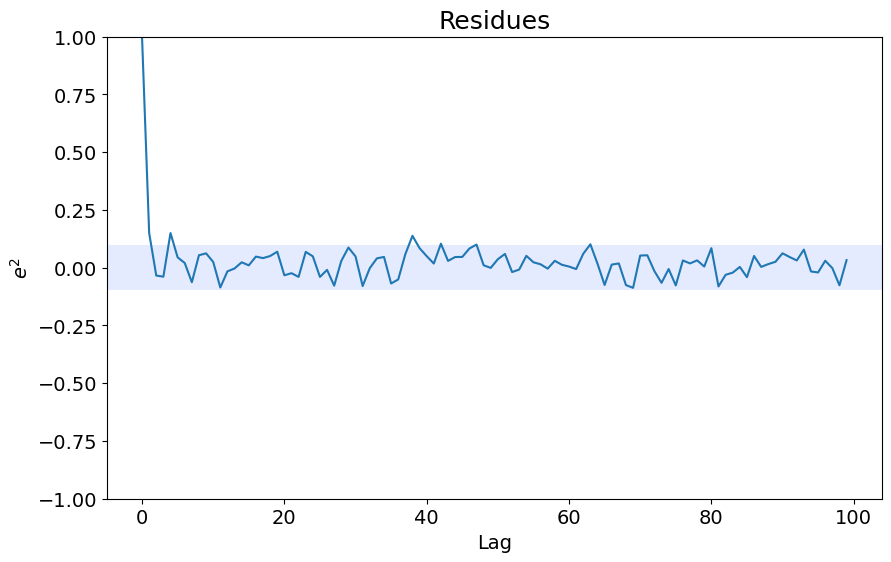

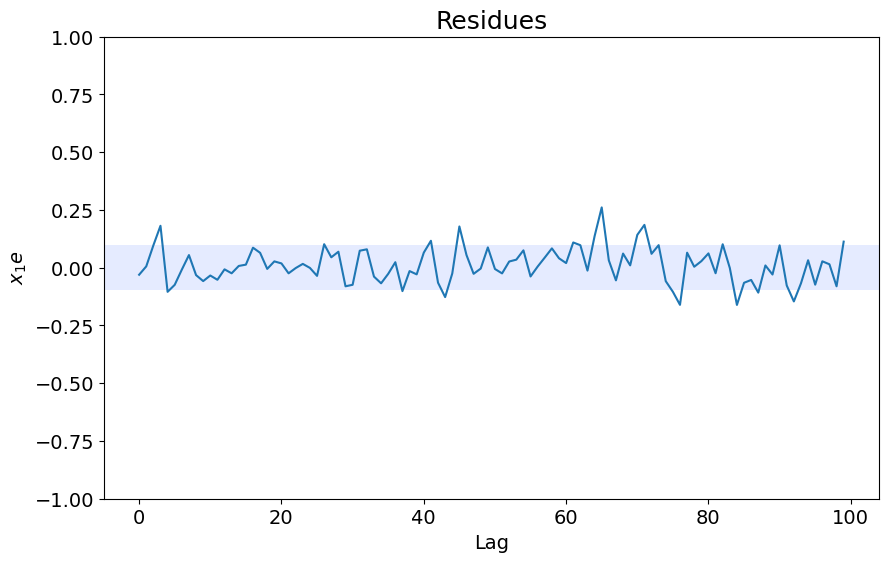

In [19]:
print("MSE: ", mean_squared_error(y_valid, yhat))
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

MSE:  0.00013285724967732702


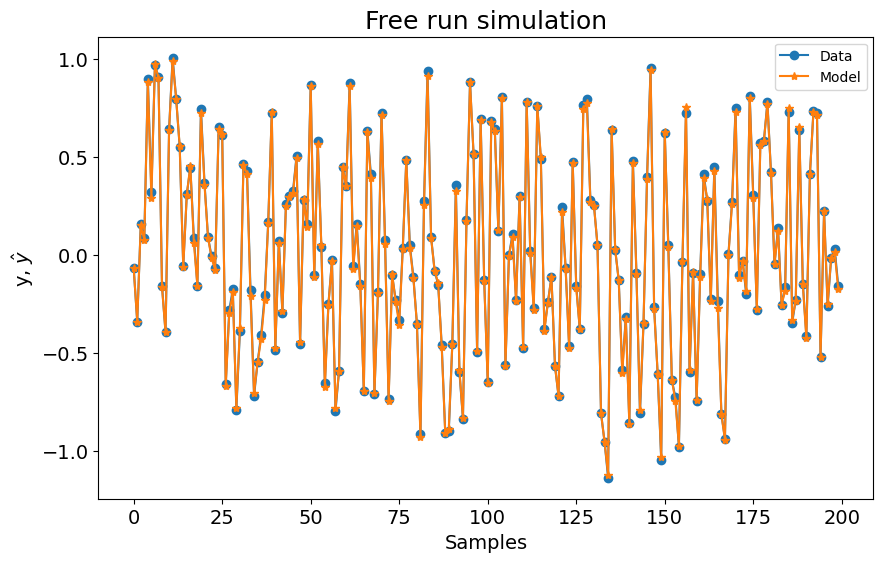

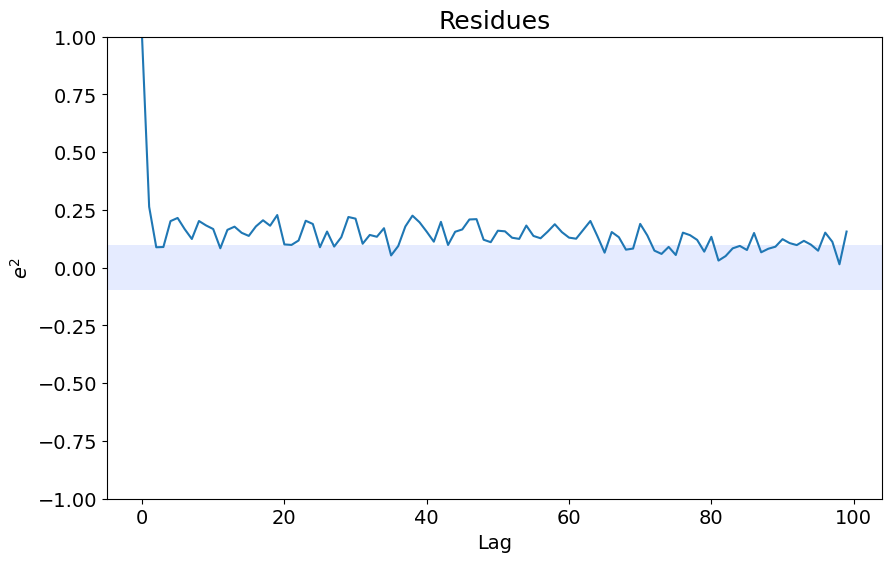

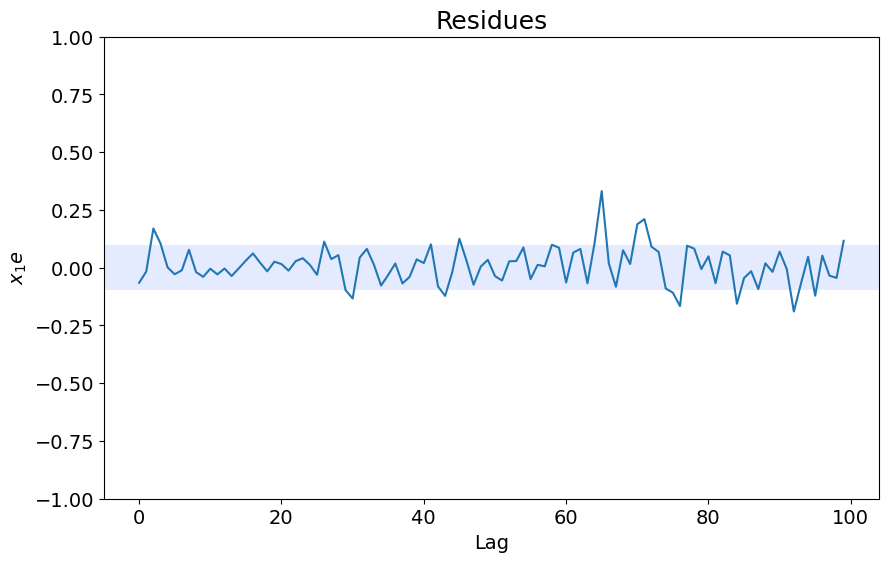

In [20]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(n_features, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z


narx_net2 = NARXNN(
    net=NARX(),
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    epochs=2000,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    },  # optional parameters of the optimizer
)

narx_net2.fit(X=x_train, y=y_train)
yhat = narx_net2.predict(X=x_valid, y=y_valid)
print("MSE: ", mean_squared_error(y_valid, yhat))

plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")